In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob

SAMPLING_RATE = 3000

hives_ids = ["ul1", "ul2", "ul3", "ul4", "ul5", "ul6"]

In [2]:
import torch
from torch import nn

class autoencoder_basic(nn.Module):
    def __init__(self):
        super(autoencoder_basic, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1501, 128),
            nn.SELU(True),
            nn.Linear(128, 64),
            nn.SELU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.SELU(True),
            nn.Linear(128, 1501),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Load train data samples

In [3]:
import struct
from datetime import datetime

hives_data = []
max_to_norm = 0
for idx, hive_id in enumerate(hives_ids):
    sound_files = [f for f in glob.glob(f"..\\measurements\\smartulav2\\{hive_id}_22082020-10092020\\*.bin")]
    print(f"Sound data preparation for hive: {hive_id} which has {len(sound_files)} recordings...", end=' ')
    for file in sound_files:
        with open(file, 'rb') as f:
            input_data = f.read()
            short_array = struct.unpack('>' + 'H' * (len(input_data) // 2), input_data)
            short_array = short_array - np.mean(short_array)
            filename = file.rsplit('\\', 1)[-1]
            timestamp = filename[filename.index('-')+1:].rsplit(".bin")[0]
            datetime = datetime.strptime(timestamp, '%Y-%m-%dT%H-%M-%S')
            hives_data.append([datetime, hive_id, short_array])
    print(" done.")

print(f"Got {len(hives_data)} sound samples ")
# # Normalize
# hives_data = [[data[0], data[1], data[2]] for data in hives_data]

Sound data preparation for hive: ul1 which has 863 recordings...  done.
Sound data preparation for hive: ul2 which has 818 recordings...  done.
Sound data preparation for hive: ul3 which has 862 recordings...  done.
Sound data preparation for hive: ul4 which has 861 recordings...  done.
Sound data preparation for hive: ul5 which has 866 recordings...  done.
Sound data preparation for hive: ul6 which has 843 recordings...  done.
Got 5113 sound samples 


Prepare data for autoencoder train.

In [33]:
rms = []
for index, data in pd_data.iterrows():
    samples = np.array(data['samples']) - np.mean(data['samples'])
    rms.append(np.sqrt(np.mean(np.abs(samples) ** 2)))

In [34]:
np.mean(rms)

32.506912

[[63.02827668 70.76073024 81.39321396 81.33140611 68.33368915 65.20787233]]


<IPython.core.display.Javascript object>


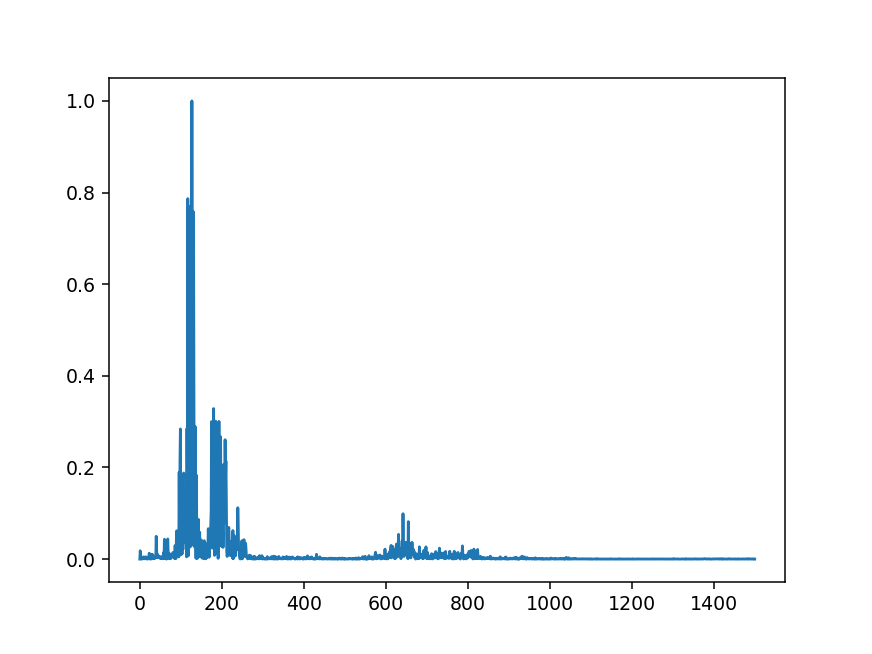

In [28]:
%matplotlib notebook

import matplotlib.pyplot as plt

a = librosa.feature.spectral_centroid(y=data['samples'], sr=3000)
print(a)
fig = plt.figure()
plt.plot(data['periodogram'])

In [4]:
import librosa
import pandas as pd

from scipy import signal as sig
from sklearn.preprocessing import MinMaxScaler
                      
pd_data = pd.DataFrame(
    {
        'samples': [hive_data[2] for hive_data in hives_data],
        'periodogram' : [sig.periodogram(hive_data[2], SAMPLING_RATE)[1] for hive_data in hives_data],
        'sn': [hive_data[1] for hive_data in hives_data]
    }
)

pd_data['periodogram'] = list(np.transpose(
    MinMaxScaler().fit_transform(np.transpose(pd_data['periodogram'].values.tolist()))))
pd_data['mfcc'] = list([np.mean(librosa.feature.mfcc(sample, sr=3000, n_fft=150, hop_length=75, n_mfcc=14), axis=1)
                           for sample in pd_data['samples'].to_numpy()])

pd_ae_data = pd_data[(pd_data['sn'] == 'ul1')]
# pd_ae_data = pd_data[(pd_data['sn'] == 1300001)
#                         | (pd_data['sn'] == 1400001)
#                         | (pd_data['sn'] == 1400002)]
pd_ae_data = pd_ae_data.sample(frac=1).reset_index(drop=True)

In [5]:
from scipy import signal as sig
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch.utils import data as tdata

# Divide data to test, validation and train
train_stop_idx = int(pd_ae_data.shape[0]*80/100)

pd_ae_data_train = pd_ae_data[:train_stop_idx]
pd_ae_data_test = pd_ae_data[train_stop_idx:]

print(f'Train data size: {pd_ae_data_train.shape[0]}')
print(f'Test data size: {pd_ae_data_test.shape[0]}')

tensor_train = torch.Tensor(pd_ae_data_train['periodogram'].values.tolist())
tensor_test = torch.Tensor(pd_ae_data_test['periodogram'].values.tolist())

train_dataset = tdata.TensorDataset(tensor_train)
test_dataset = tdata.TensorDataset(tensor_test)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train data size: 690
Test data size: 173


## Train

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F

num_epochs = 1000
learning_rate = 1e-3

model = autoencoder_basic().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    loss = 0
    for data in dataloader:
        periodogram = data[0].to(device)
        # ===================forward=====================
        output = model(periodogram)
        #train_loss = criterion(output, periodogram)
        train_loss = F.binary_cross_entropy(output, periodogram)
        # ===================backward====================
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(dataloader)
    print(f'epoch {epoch + 1}/{num_epochs}, loss:{loss}')

epoch 1/1000, loss:0.40868771143934945
epoch 2/1000, loss:0.11075225946578113
epoch 3/1000, loss:0.08950847996906801
epoch 4/1000, loss:0.08318054574457082
epoch 5/1000, loss:0.08018068224191666
epoch 6/1000, loss:0.07898091524839401
epoch 7/1000, loss:0.07882293821735815
epoch 8/1000, loss:0.07883607968688011
epoch 9/1000, loss:0.07830178619108417
epoch 10/1000, loss:0.07840240408073772
epoch 11/1000, loss:0.07775355824692683
epoch 12/1000, loss:0.07807844250716946
epoch 13/1000, loss:0.07781148583374241
epoch 14/1000, loss:0.07769271020184863
epoch 15/1000, loss:0.07776289992034435
epoch 16/1000, loss:0.0782436535439708
epoch 17/1000, loss:0.07825897041369569
epoch 18/1000, loss:0.07779186862436208
epoch 19/1000, loss:0.0775815968147733
epoch 20/1000, loss:0.07786626470359889
epoch 21/1000, loss:0.07771633108231155
epoch 22/1000, loss:0.07737995497882366
epoch 23/1000, loss:0.0779817087406462
epoch 24/1000, loss:0.07802201942964034
epoch 25/1000, loss:0.07775806432420557
epoch 26/100

## Test

In [8]:
import matplotlib.pyplot as plt

counter = 0
with torch.no_grad():
    loss_test = 0
    for data in dataloader_test:
        periodograms_test = data[0].to(device)
        output = model(periodograms_test)
        for idx, i in enumerate(output):
            #loss_test += nn.MSELoss()(periodograms_test[idx], i)
            loss_test += F.binary_cross_entropy(periodograms_test[idx], i)

loss_test = loss_test/len(pd_ae_data_test)
print(f'Final test loss: {loss_test}')


Final test loss: 0.12012351304292679


Plot and visualize (MFCC vs AE)

In [9]:
import matplotlib.pyplot as plt

with torch.no_grad():
    encode_data = pd_ae_data['periodogram'].values.tolist()
    encode_data_tensor = torch.Tensor(encode_data).to(device)
    output = [model.encoder(encode_data_tensor).cpu().numpy()][0]


In [11]:
%matplotlib widget
import matplotlib.pyplot as plt

idx =708
with torch.no_grad():
    fig = plt.figure()
    plt.figure(figsize=(8,4))
    plt.plot(encode_data[idx], 'r')
    plt.plot(model.decoder(torch.Tensor(output[idx]).to(device)).cpu().numpy(), 'b')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Dimension reduction - now we perform t-SNE and PCA to visualize the data

In [35]:
from sklearn.manifold import TSNE

reduced_ae_tsne = TSNE(n_components=2, perplexity=100, learning_rate=500, verbose=1).fit_transform(output)
reduced_mfcc_tsne = TSNE(n_components=2, perplexity=100, learning_rate=500, verbose=1).fit_transform(pd_ae_data['mfcc'].values.tolist())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1652 samples in 0.005s...
[t-SNE] Computed neighbors for 1652 samples in 0.308s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1652
[t-SNE] Computed conditional probabilities for sample 1652 / 1652
[t-SNE] Mean sigma: 1.234582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.237263
[t-SNE] KL divergence after 1000 iterations: 0.891569
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1652 samples in 0.001s...
[t-SNE] Computed neighbors for 1652 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1652
[t-SNE] Computed conditional probabilities for sample 1652 / 1652
[t-SNE] Mean sigma: 6.598951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.734734
[t-SNE] KL divergence after 1000 iterations: 1.001012


In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mfccs_standarized = StandardScaler().fit_transform(pd_ae_data['mfcc'].values.tolist())
ae_standarized = StandardScaler().fit_transform(output)
reduced_ae_pca = PCA(n_components = 2).fit_transform(ae_standarized)
reduced_mfcc_pca = PCA(n_components = 2).fit_transform(mfccs_standarized)

<IPython.core.display.Javascript object>


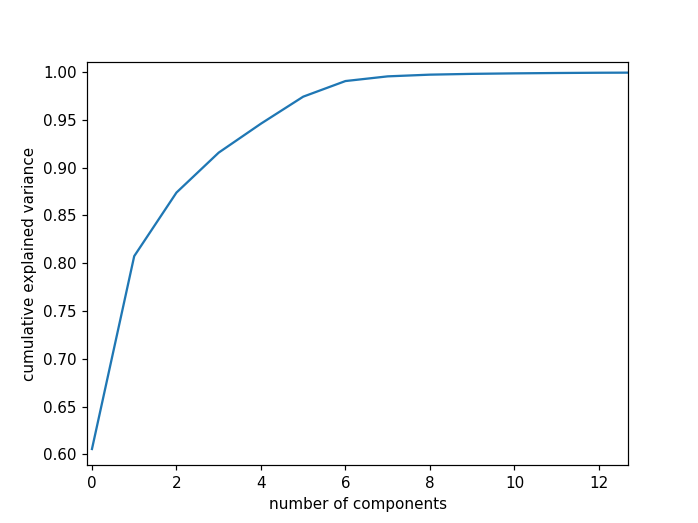

In [21]:
import matplotlib.pyplot as plt

pca = PCA().fit(ae_standarized)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [90]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.005), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=43, verbose=0, behaviour="new")

clf.fit(reduced_ae_pca)
clf.get_params(deep=True)

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.005,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 43,
 'verbose': 0,
 'warm_start': False}

In [84]:
output_forest = clf.predict(reduced_ae_pca)

<IPython.core.display.Javascript object>


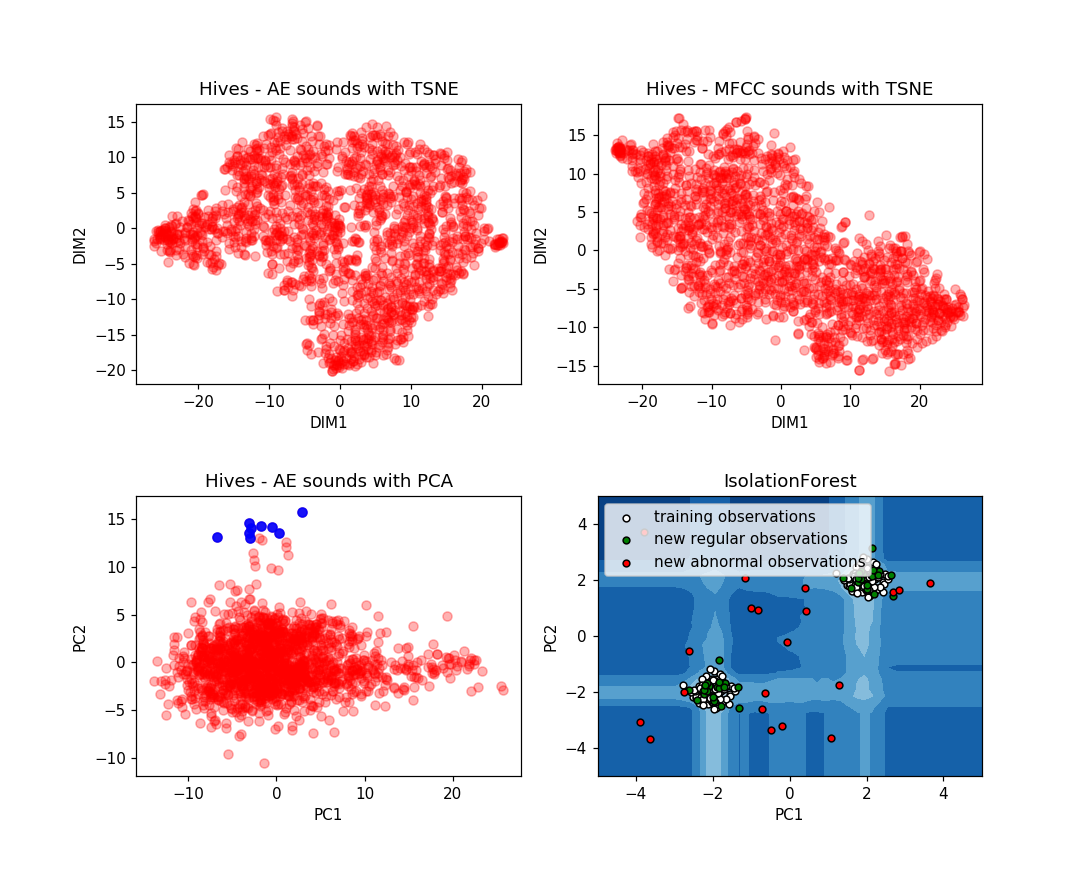

Text(0.5, 1.0, 'Hives - MFCC sounds with PCA')

In [85]:
%matplotlib notebook

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)

idx_1300001 = pd_data[pd_data['sn'] == 1300001].index.values.tolist()
idx_1300002 = pd_data[pd_data['sn'] == 1300002].index.values.tolist()
idx_1400001 = pd_data[pd_data['sn'] == 1400001].index.values.tolist()
idx_1400002 = pd_data[pd_data['sn'] == 1400002].index.values.tolist()

l1_ae_tsne = axs[0][0].scatter([data[0] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1300001],
                 [data[1] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1300001], c='r', alpha = 0.3)
# l2_ae_tsne = axs[0][0].scatter([data[0] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1300002],
#                  [data[1] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1300002], c='b', alpha = 0.3)
# l3_ae_tsne = axs[0][0].scatter([data[0] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1400001],
#                  [data[1] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1400001], c='g', alpha = 0.3)
# l4_ae_tsne = axs[0][0].scatter([data[0] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1400002],
#                  [data[1] for idx, data in enumerate(reduced_ae_tsne) if idx in idx_1400002], c='y', alpha = 0.3)

l1_mfcc_tsne = axs[0][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1300001],
                 [data[1] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1300001], c='r', alpha = 0.3)
# l2_mfcc_tsne = axs[0][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1300002],
#                  [data[1] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1300002], c='b', alpha = 0.3)
# l3_mfcc_tsne = axs[0][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1400001],
#                  [data[1] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1400001], c='g', alpha = 0.3)
# l4_mfcc_tsne = axs[0][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1400002],
#                  [data[1] for idx, data in enumerate(reduced_mfcc_tsne) if idx in idx_1400002], c='y', alpha = 0.3)

# axs[0][0].legend((l1_ae_tsne, l2_ae_tsne, l3_ae_tsne, l4_ae_tsne), ('Sikorki', 'Not Hive', 'Sulmin 1', 'Sulmin 2'),
#                  loc='upper right')
axs[0][0].set_xlabel('DIM1')
axs[0][0].set_ylabel('DIM2')
axs[0][0].set_title('Hives - AE sounds with TSNE')

# axs[0][1].legend((l1_mfcc_tsne, l2_mfcc_tsne, l3_mfcc_tsne, l4_mfcc_tsne), ('Sikorki', 'Not Hive', 'Sulmin 1', 'Sulmin 2'),
#                  loc='upper right')
axs[0][1].set_xlabel('DIM1')
axs[0][1].set_ylabel('DIM2')
axs[0][1].set_title('Hives - MFCC sounds with TSNE')

l1_ae_pca = axs[1][0].scatter([data[0] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1300001],
                 [data[1] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1300001], c='r', alpha = 0.3)
markers = axs[1][0].scatter([data[0] for idx, data in enumerate(reduced_ae_pca) if output_forest[idx] == -1],
                           [data[1] for idx, data in enumerate(reduced_ae_pca) if output_forest[idx] == -1], c='b', alpha = 0.9)
# l2_ae_pca = axs[1][0].scatter([data[0] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1300002],
#                  [data[1] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1300002], c='b', alpha = 0.3)
# l3_ae_pca = axs[1][0].scatter([data[0] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1400001],
#                  [data[1] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1400001], c='g', alpha = 0.3)
# l4_ae_pca = axs[1][0].scatter([data[0] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1400002],
#                  [data[1] for idx, data in enumerate(reduced_ae_pca) if idx in idx_1400002], c='y', alpha = 0.3)

l1_mfcc_pca = axs[1][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1300001],
                 [data[1] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1300001], c='r', alpha = 0.3)
# l2_mfcc_pca = axs[1][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1300002],
#                  [data[1] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1300002], c='b', alpha = 0.3)
# l3_mfcc_pca = axs[1][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1400001],
#                  [data[1] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1400001], c='g', alpha = 0.3)
# l4_mfcc_pca = axs[1][1].scatter([data[0] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1400002],
#                  [data[1] for idx, data in enumerate(reduced_mfcc_pca) if idx in idx_1400002], c='y', alpha = 0.3)

# axs[1][0].legend((l1_ae_pca, l2_ae_pca, l3_ae_pca, l4_ae_pca), ('Sikorki', 'Not Hive', 'Sulmin 1', 'Sulmin 2'),
#                  loc='upper right')
axs[1][0].set_xlabel('PC1')
axs[1][0].set_ylabel('PC2')
axs[1][0].set_title('Hives - AE sounds with PCA')

# axs[1][1].legend((l1_mfcc_pca, l2_mfcc_pca, l3_mfcc_pca, l4_mfcc_pca), ('Sikorki', 'Not Hive', 'Sulmin 1', 'Sulmin 2'),
#                   loc='upper right')
axs[1][1].set_xlabel('PC1')
axs[1][1].set_ylabel('PC2')
axs[1][1].set_title('Hives - MFCC sounds with PCA')



In [ ]:
plt.savefig('output-ae/basic-2warstwy-128-32.png')